# Quantum Error Correction

### Three bit effective qubits
The quantum analog to the classical three bit replication code 
$$
\begin{align}
a \vert 0 \rangle + b\vert 1\rangle \mapsto~
&~~CX_{13}CX_{12}\big( a \vert 0 \rangle + b\vert 1\rangle \big)\vert 00\rangle \\
&= CX_{13}\big( a \vert 00 \rangle + b\vert 11\rangle \big)\vert 0\rangle \\
&= a \vert 000\rangle + b\vert 111\rangle  
\end{align}
$$
yields the effective qubit state $a \vert 000\rangle + b\vert 111\rangle$. 


## Bit errors
If transmission of the three bit effective qubit state is subject to bit wise binary symmetric channel noise with via the Kraus operator $E_{p,\text{bit}}$ such that an $n$-qubit state's density operators $\rho$ are modified as
$$
E_{p,\text{bit}}(\rho) = (1-p)\rho + p X\rho X 
$$
then error correction can be done with 
$$
{\cal E}_{\text{corr}} = P_0 + \sum_i X_i P_i
$$
where $X_i$ is Pauli X applied to the $i$th qubit and
$$
\begin{align}
P_0 = \vert 000 \rangle \langle  000 \vert + \vert 111 \rangle \langle 111\vert ,\\
P_1 = \vert 100 \rangle \langle  100 \vert + \vert 011 \rangle \langle 011\vert ,\\
P_0 = \vert 010 \rangle \langle  010 \vert + \vert 101 \rangle \langle 101\vert, \\
P_0 = \vert 001 \rangle \langle  001 \vert + \vert 110 \rangle \langle 110\vert \,.\\
\end{align}
$$


The probability of a 2 bit error is the same as in classical 3 bit repetition code. Two qubit errors are not corrected. 

The matrix of ${\cal E}_{\text{corr}}$ is calculated below. 

In [5]:
import numpy as np
import pennylane as qml

first_kets = np.array([[0,0,0],[1,0,0],[0,1,0],[0,0,1]])
second_kets = np.array([(ket + 1)%2 for ket in first_kets])

Ps = np.array([np.zeros((8,8)) for _ in range(4)])
for i in range(4):
    first_index  = np.ravel_multi_index(first_kets[i], [2]*3)
    second_index = np.ravel_multi_index(second_kets[i],[2]*3)
    Ps[i,first_index,first_index] = 1
    Ps[i,second_index,second_index] = 1

X = np.array([[0,1],[1,0]])
I = np.eye(2)
Xs = [np.eye(8) ,
      np.kron(np.kron(X,I),I),
      np.kron(np.kron(I,X),I),
      np.kron(np.kron(I,I),X)
     ]

E = sum([ Xs[i]@Ps[i] for i in range(4)])
# E = qml.QubitUnitary(E, wires =range(3))
E # The fluent reader can see here that E is the right matrix. 

array([[1., 1., 1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 1., 1., 1.]])

Below are checks that corrupted qubits are corrected. The three qubit state $\vert 001\rangle$ should be corrected to the state $\vert 000\rangle$. The latter, in the computation basis, has components [1,0,....,0].

In [631]:
corrupted_logical_qubit = [0,0,1]
corrupted_state = np.zeros(8) # Initializing
corrupted_state[np.ravel_multi_index(corrupted_logical_qubit,[2]*3)] = 1 # one non-zero component 
E = sum( [ Xs[i]@Ps[i] for i in range(4)])
E@corrupted_state


array([1., 0., 0., 0., 0., 0., 0., 0.])

This matrix is equal to that of to $MCX_{120}CX_{02}CX_{01}$, as seen below. 

In [4]:
# Not working for me :(
mat1 = (qml.CNOT(wires = [0,1])@qml.I(wires=[2])).matrix()
mat2 = (qml.CNOT(wires = [0,2])@qml.I(wires=[1])).matrix()
mat3 = (qml.Toffoli(wires = [1,2,0])).matrix()
mat3@mat2@mat1

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

## Phase flip

For correcting a phase flip (which is a flip by $Z$, analogous to how a bit flip is a flip by $X$)
further encode with $H^{\otimes 3}$ to get 
$$
\begin{align}
a \vert 0 \rangle + b\vert 1\rangle \mapsto~
&~~H^{\otimes 3} CX_{13}CX_{12}\big( a \vert 0 \rangle + b\vert 1\rangle \big)\vert 00\rangle \\
&= H^{\otimes 3} \big(a\vert 00 0\rangle + b\vert 111\rangle\big) \\ 
&=  a\vert +++ \rangle + b\vert ---\rangle \\ 
\end{align}
$$

In transmission, a phase flip may occur, e.g in the first component giving 
$$
a\vert -++ \rangle + b\vert +--\rangle\big) \\ 
$$
This can be corrected by applying $H^3$ to get 
$$
a\vert 100 \rangle + b\vert 011\rangle\big) \\ 
$$
and then applying the bit error correction via ${\cal E}_{\text{corr}}$. 

### Shor's Algorithm

Shor's algorithm simultaneously applies bit flip and phase flip corrections by increasing the number of ancilla qubits to 8, so the system has 9 qubits.  

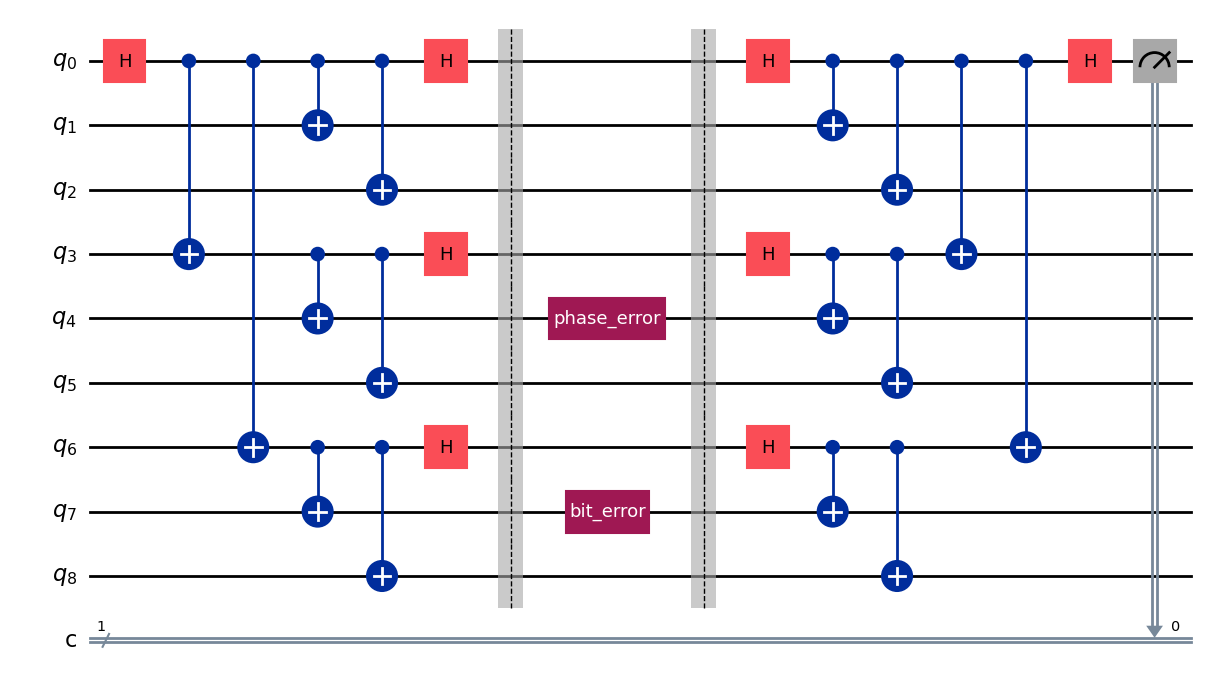

In [13]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt

def shors_encoding_circuit():
    qc = QuantumCircuit(9, name='Encoding')
    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 6)
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)
    qc.h([0, 3, 6])
    return qc

def shors_decoding_circuit():
    qc = QuantumCircuit(9, name='Decoding')
    qc.h([0, 3, 6])
    # Measure syndromes and correct errors
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)    
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h(0)
    return qc

# Function to create the full Shor's error correction circuit.
def shors_error_correction_circuit(bit_error_gate=None, phase_error_gate=None, 
                                   bit_error_qubit=None, phase_error_qubit=None):
    qc = QuantumCircuit(9, 1)
    qc.compose(shors_encoding_circuit(), inplace=True)
    qc.barrier()
    # Introduce one bit and one phase error.
    if bit_error_gate and bit_error_qubit is not None:
        qc.append(bit_error_gate, [bit_error_qubit])
    if phase_error_gate and phase_error_qubit is not None:
        qc.append(phase_error_gate, [phase_error_qubit])    
    qc.barrier()
    qc.compose(shors_decoding_circuit(), inplace=True)
    # Measure on wire 0 and send the result to classical register.
    qc.measure(0, 0)    
    return qc

# Select random qubit indices to apply the bit error and phase error
bit_error_qubit = np.random.choice(a=range(9))
phase_error_qubit = np.random.choice(a=range(9))

# Define an error gate (Pauli-X error) and name it "bit_error"
bit_error_gate = QuantumCircuit(1, name="bit_error")
bit_error_gate.x(0)
bit_error_gate = bit_error_gate.to_instruction()

# Define a phase error gate (Pauli-Z error) and name it "phase_error".
phase_error_gate = QuantumCircuit(1, name="phase_error")
phase_error_gate.z(0)
phase_error_gate = phase_error_gate.to_instruction()

# Create the full Shor's error correction circuit with a bit error and a phase error.
shors_circuit = shors_error_correction_circuit(
    bit_error_gate=bit_error_gate,
    phase_error_gate=phase_error_gate,
    bit_error_qubit=bit_error_qubit,
    phase_error_qubit=phase_error_qubit
)

# Draw the circuit.
shors_circuit.draw(output='mpl')


# Visualize in and out vectors. 

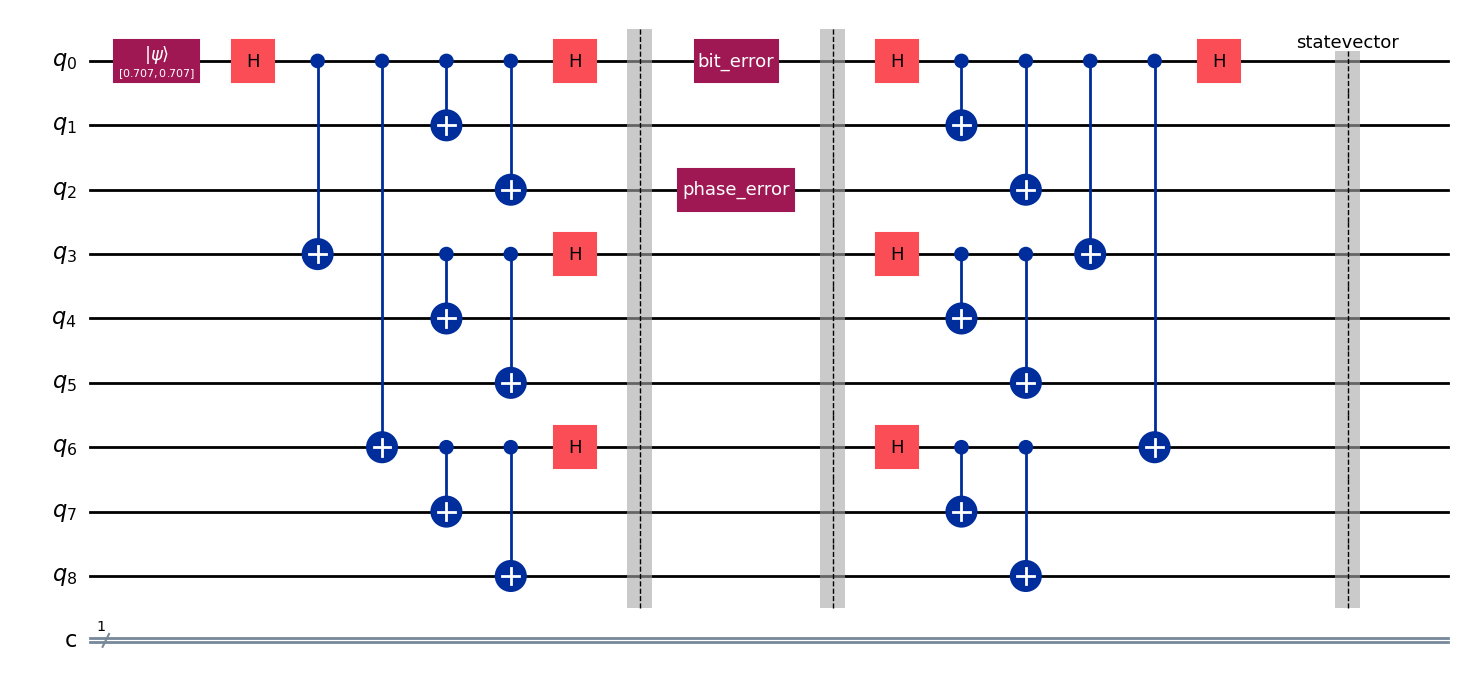

In [2]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import partial_trace, Statevector
from qiskit.visualization import plot_state_city
import matplotlib.pyplot as plt

# Function to create Shor's encoding circuit.
def shors_encoding_circuit():
    qc = QuantumCircuit(9, name='Encoding')
    
    # Encode the logical qubit.
    qc.h(0)
    qc.cx(0, 3)
    qc.cx(0, 6)
    
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)
    
    # Apply Hadamard gates to handle phase flip errors.
    qc.h([0, 3, 6])
    
    return qc

# Function to create Shor's decoding circuit.
def shors_decoding_circuit():
    qc = QuantumCircuit(9, name='Decoding')
    
    # Apply Hadamard gates to handle phase flip errors.
    qc.h([0, 3, 6])
    
    # Measure syndromes and correct errors.
    for i in range(3):
        qc.cx(i*3, i*3 + 1)
        qc.cx(i*3, i*3 + 2)
    
    qc.cx(0, 3)
    qc.cx(0, 6)
    qc.h(0)
    
    return qc

# Function to create the full Shor's error correction circuit.
def shors_error_correction_circuit(bit_error_gate=None, phase_error_gate=None, bit_error_qubit=None, phase_error_qubit=None):
    qc = QuantumCircuit(9, 1)
    
    # Encoding part.
    qc.compose(shors_encoding_circuit(), inplace=True)
    
    # Add barrier after encoding.
    qc.barrier()
    
    # Introduce bit error on the specified random qubit.
    if bit_error_gate and bit_error_qubit is not None:
        qc.append(bit_error_gate, [bit_error_qubit])
    
    # Introduce phase error on the specified random qubit.
    if phase_error_gate and phase_error_qubit is not None:
        qc.append(phase_error_gate, [phase_error_qubit])
    
    # Add barrier after errors.
    qc.barrier()
    
    # Decoding part.
    qc.compose(shors_decoding_circuit(), inplace=True)
    
    # Save the statevector at the end of the circuit.
    qc.save_statevector(label="statevector")
    
    return qc

# Select random qubit indices to apply the bit error and phase error.
bit_error_qubit = np.random.choice(a=range(9))
phase_error_qubit = np.random.choice(a=range(9))

# Define an error gate (Pauli-X error) and name it "bit_error".
bit_error_gate = QuantumCircuit(1, name="bit_error")
bit_error_gate.x(0)
bit_error_gate = bit_error_gate.to_instruction()

# Define a phase error gate (Pauli-Z error) and name it "phase_error".
phase_error_gate = QuantumCircuit(1, name="phase_error")
phase_error_gate.z(0)
phase_error_gate = phase_error_gate.to_instruction()

# Create the full Shor's error correction circuit with a bit error and a phase error.
shors_circuit = shors_error_correction_circuit(
    bit_error_gate=bit_error_gate,
    phase_error_gate=phase_error_gate,
    bit_error_qubit=bit_error_qubit,
    phase_error_qubit=phase_error_qubit
)

# Define the initial state for the 0th qubit.
initial_state = [1/np.sqrt(2), 1/np.sqrt(2)]  # Example: |+> state

# Create the initial state preparation circuit.
init_circuit = QuantumCircuit(9)
init_circuit.initialize(initial_state, 0)

# Combine the initial state preparation circuit with the Shor's circuit.
full_circuit = init_circuit.compose(shors_circuit)

# Draw the full circuit.
full_circuit.draw(output='mpl')

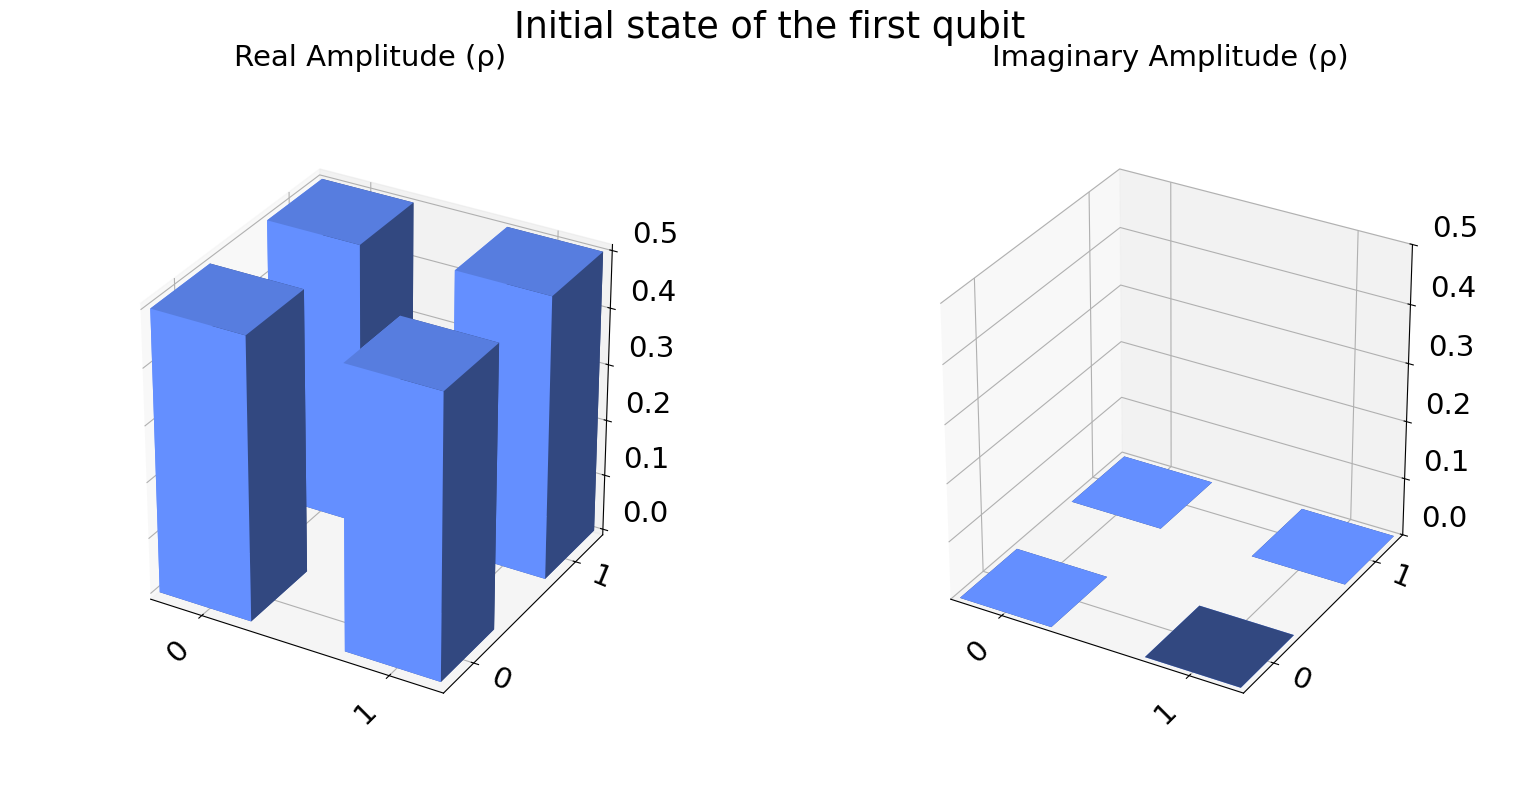

In [ ]:
# Use the AerSimulator for statevector simulation.
simulator = AerSimulator(method="statevector")

# Transpile the circuit for the simulator.
transpiled_circ = transpile(full_circuit, simulator)

# Run the simulation.
result = simulator.run(transpiled_circ).result()

# Get the statevector from the result.
statevector = result.data()['statevector']

# Convert the statevector to a Statevector object.
statevector = Statevector(statevector)

# Reduce the statevector to the first qubit.
initial_statevector = Statevector(initial_state)
reduced_state_initial = partial_trace(initial_statevector.tensor(Statevector.from_label('0'*8)), range(1, 9))
reduced_state_final = partial_trace(statevector, range(1, 9))

# # Visualize the initial and final statevectors using the state city plot.
# fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Set the current axes and plot the initial state.
# plt.sca(axes[0])
# plt.ylim(0,1)
plot_state_city(initial_state,  title='Initial state of the first qubit')

# Shor module

In this section, I will create a module that facilitates 
- taking in a sequence of length $n_qubit$ of one qubit state vectors
- Shor encoding
- applying a series of gates that is the identity except for quantum noise
- shor decoding

to evaluate the ability of the Shor algorithm to correct the errors from quantum noise. 

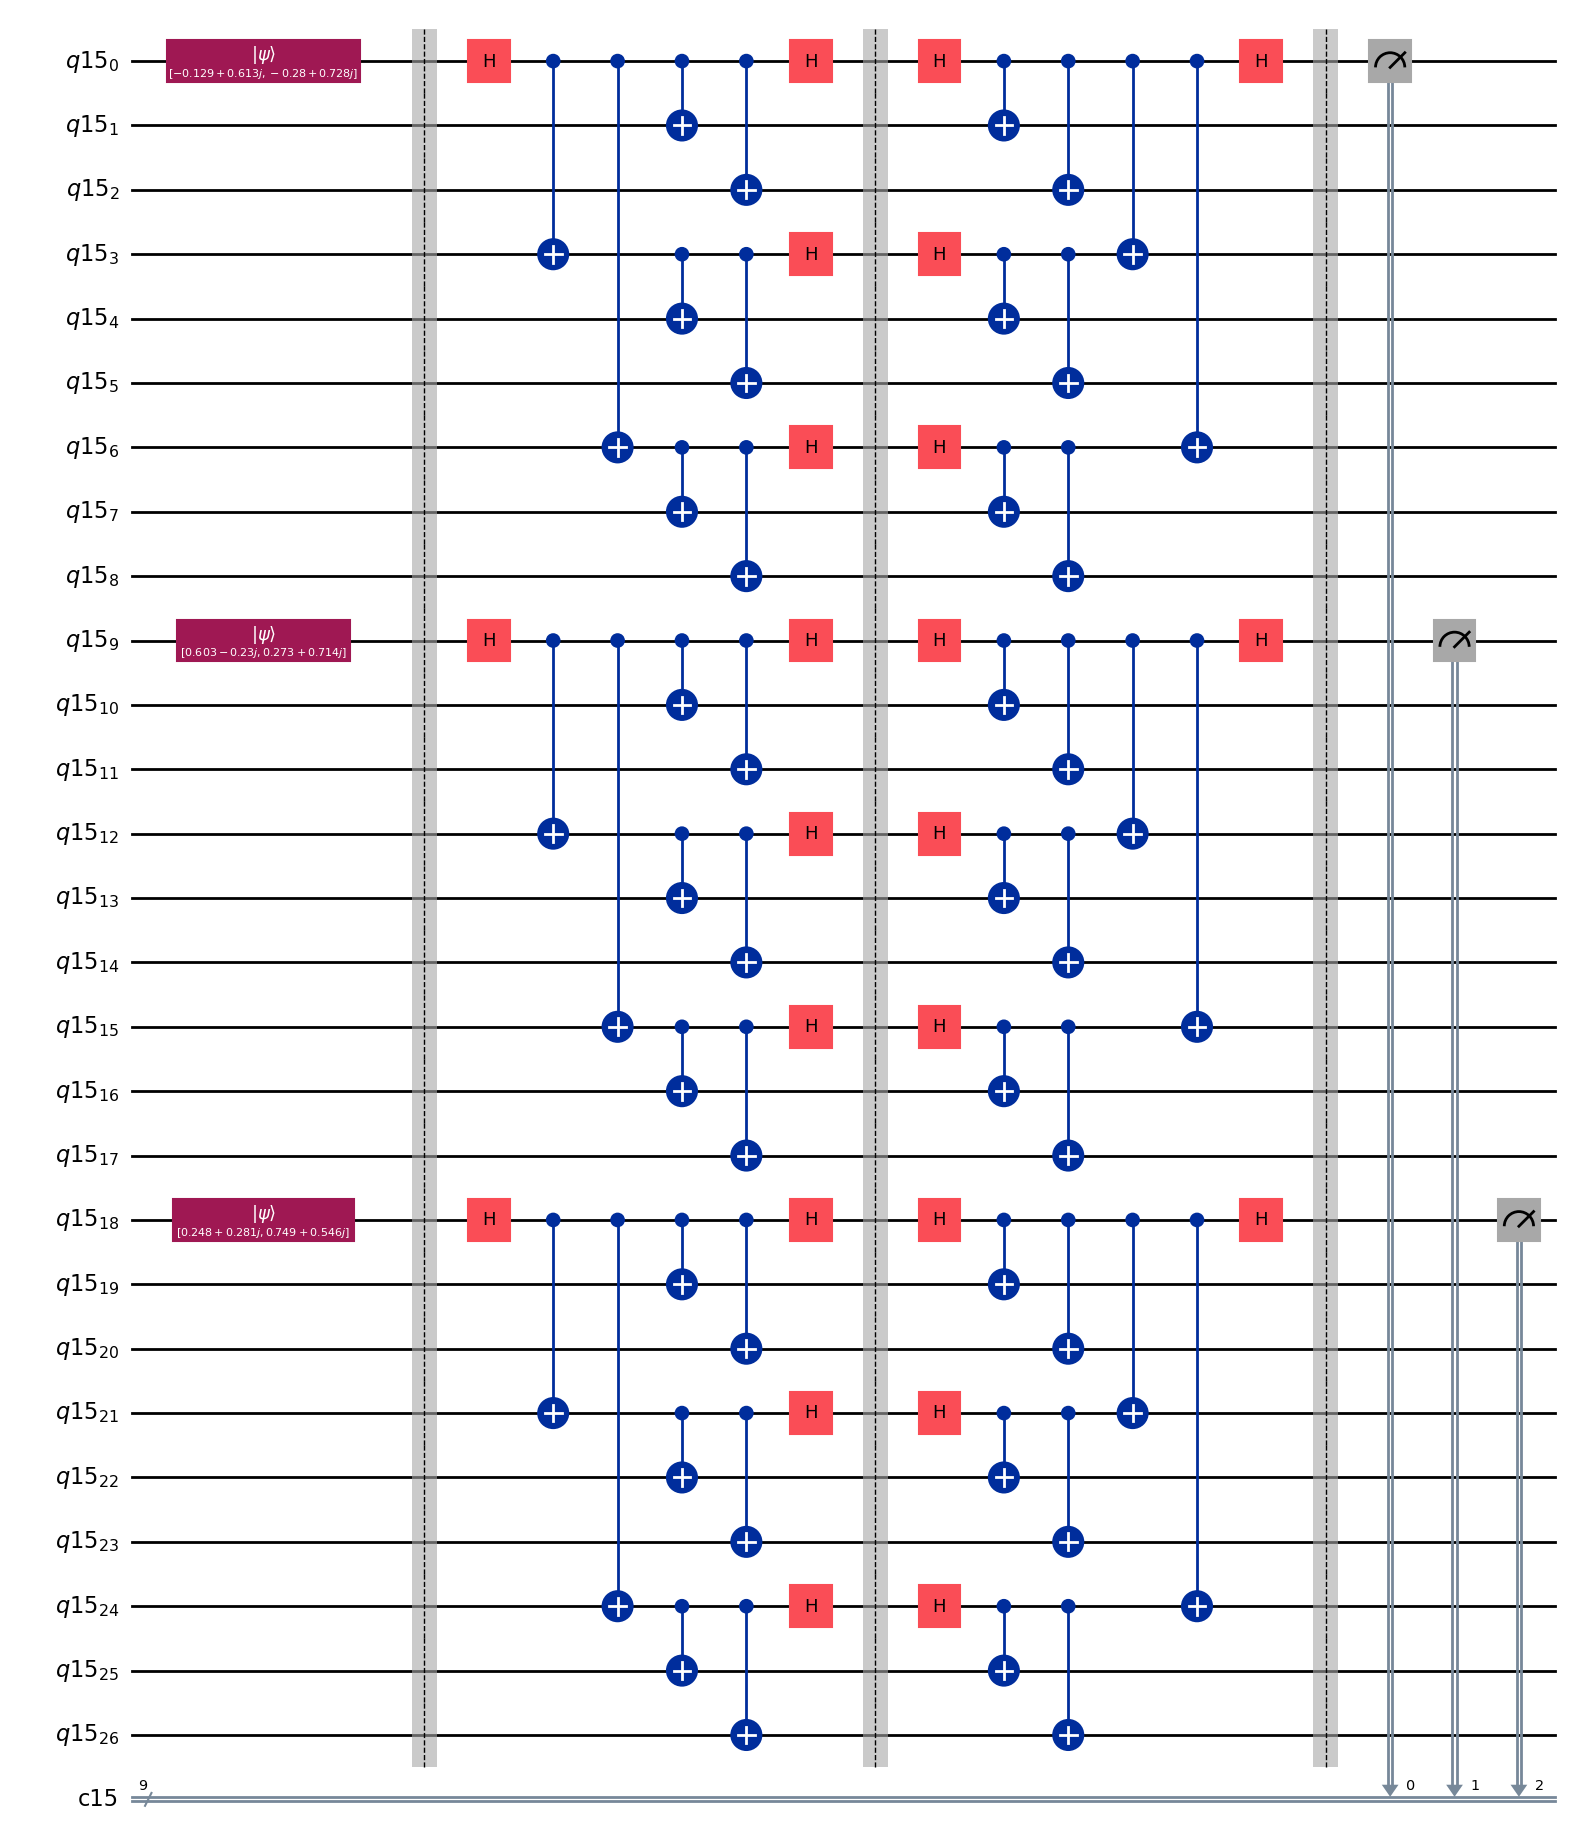

In [8]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.quantum_info import random_statevector

def generate_random_states(n_qubits):
    """
    Generates random state vectors for the given number of qubits.

    Args:
        n_qubits (int): Number of qubits.

    Returns:
        list: List of random state vectors.
    """
    state_vectors = [random_statevector(2) for _ in range(n_qubits)]
    return state_vectors

def shor_encode(n_qubits, state_vectors):
    """
    Initializes a quantum circuit with a given state vector and applies Shor encoding.

    Args:
        n_qubits (int): Number of logical qubits.
        state_vectors (list or numpy array): List of state vectors to initialize the circuit with.

    Returns:
        QuantumCircuit: The initialized and encoded quantum circuit.
    """
    qr = QuantumRegister(9 * n_qubits)
    cr = ClassicalRegister(3 * n_qubits)
    qc = QuantumCircuit(qr, cr)
    
    # Initialize the state vector on the primary wires
    for i in range(n_qubits):
        qc.initialize(state_vectors[i], [qr[9 * i]])

    qc.barrier()
    
    # Perform Shor encoding
    for qubit in range(n_qubits):
        start = qubit * 9
        # Encode the logical qubit
        qc.h(qr[start])
        qc.cx(qr[start], qr[start + 3])
        qc.cx(qr[start], qr[start + 6])
        
        for i in range(3):
            qc.cx(qr[start + i * 3], qr[start + i * 3 + 1])
            qc.cx(qr[start + i * 3], qr[start + i * 3 + 2])
        
        # Apply Hadamard gates to handle phase flip errors
        qc.h([qr[start], qr[start + 3], qr[start + 6]])

    qc.barrier()
    return qc

def shor_decode(n_qubits=1):
    """Creates a Shor decoding circuit for n qubits."""
    qr = QuantumRegister(9 * n_qubits)
    cr = ClassicalRegister(3 * n_qubits)
    qc = QuantumCircuit(qr, cr, name='Decoding')
    
    for qubit in range(n_qubits):
        start = qubit * 9
        # Apply Hadamard gates to handle phase flip errors
        qc.h([qr[start], qr[start + 3], qr[start + 6]])
        
        # Correct bit flip errors
        for i in range(3):
            qc.cx(qr[start + i * 3], qr[start + i * 3 + 1])
            qc.cx(qr[start + i * 3], qr[start + i * 3 + 2])
        
        qc.cx(qr[start], qr[start + 3])
        qc.cx(qr[start], qr[start + 6])
        qc.h(qr[start])
        
        # Measure the ancilla qubits
        # qc.measure([qr[start + 1], qr[start + 2], qr[start + 4], qr[start + 5], qr[start + 7], qr[start + 8]], 
                   # [cr[3 * qubit], cr[3 * qubit + 1], cr[3 * qubit + 2]])
    
    qc.barrier()
    return qc

# Example usage
n_qubits = 3
random_states = generate_random_states(n_qubits)

# Create the initial circuit with Shor encoding
initial_circuit = shor_encode(n_qubits=n_qubits, state_vectors=random_states)

# Create the decoding circuit
decoding_circuit = shor_decode(n_qubits=n_qubits)

# Concatenate the encoding and decoding circuits
complete_circuit = initial_circuit.compose( decoding_circuit)

# Add classical registers for the final measurement of logical qubits
final_qr = QuantumRegister(9 * n_qubits)
final_cr = ClassicalRegister(n_qubits)
final_measurements = QuantumCircuit(final_qr, final_cr)

# Measure the primary qubits
for i in range(n_qubits):
    final_measurements.measure(final_qr[9 * i], final_cr[i])

# Append the final measurements to the complete circuit
complete_circuit = complete_circuit.compose(final_measurements)

# Print the complete circuit
complete_circuit.draw("mpl")


### Using a modules

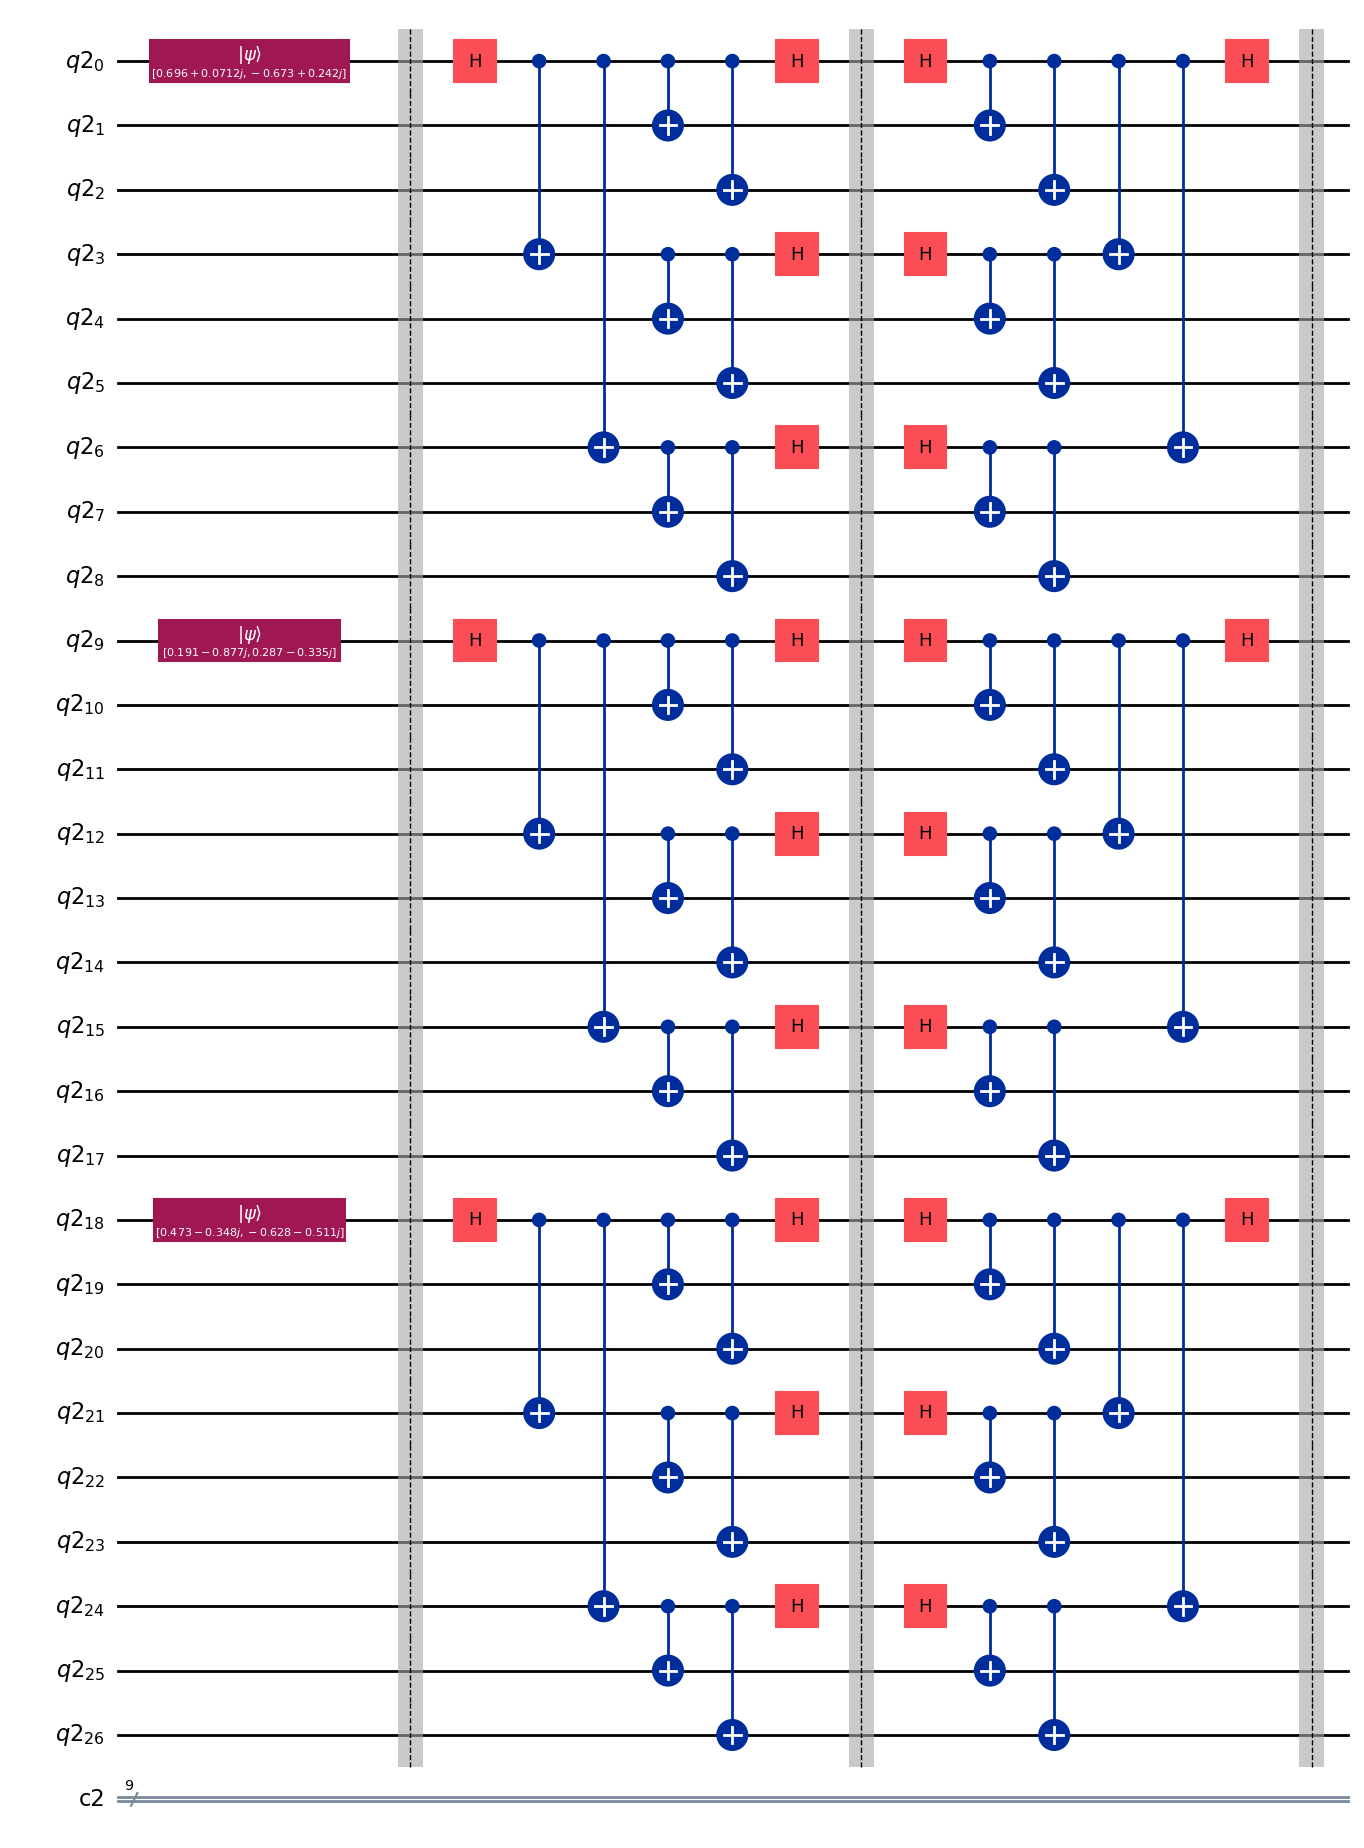

In [2]:
from utils import generate_random_states
from shor import shor_encode, shor_decode


# Example usage
n_qubits = 3
random_states = generate_random_states(n_qubits)
initial_circuit = shor_encode(n_qubits=n_qubits, state_vectors=random_states)
decoding_circuit = shor_decode(n_qubits=n_qubits)
complete_circuit = initial_circuit.compose(decoding_circuit)
complete_circuit.draw("mpl")


In [3]:
from qiskit.visualization import plot_circuit_layout


In [4]:
plot_circuit_layout(complete_circuit)

TypeError: plot_circuit_layout() missing 1 required positional argument: 'backend'

In [6]:
import numpy as np
from utils import generate_random_states
from shor import shor_encode, shor_decode, trace_over_ancilla_qubits
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_city

# Example usage
n_qubits = 2
random_states = generate_random_states(n_qubits)
initial_combined_state = np.kron(*[state.data for state in random_states])
initial_statevector = Statevector(initial_combined_state)

initial_circuit = shor_encode(n_qubits=n_qubits, state_vectors=random_states)
decoding_circuit = shor_decode(n_qubits=n_qubits)

# Concatenate the encoding and decoding circuits
complete_circuit = initial_circuit.compose(decoding_circuit)

# Simulate the complete circuit to get the final statevector
simulator = AerSimulator()
complete_circuit.save_statevector()
result = simulator.run(complete_circuit).result()
final_state = result.get_statevector()

reduced_state_vector = trace_over_ancilla_qubits(final_state,n_qubits).to_statevector()
# Plot the final statevector
#plot_state_city(reduced_state)
fidelity = state_fidelity(initial_statevector, reduced_state_vector)

In [12]:
state_diff = np.array(initial_statevector)-np.array(reduced_state_vector)

Fidelity between states $\rho_1,\rho_2$ is the quantity $F(\rho_1, \rho_2) = Tr[\sqrt{\sqrt{\rho_1}\rho_2\sqrt{\rho_1}}]^2.$

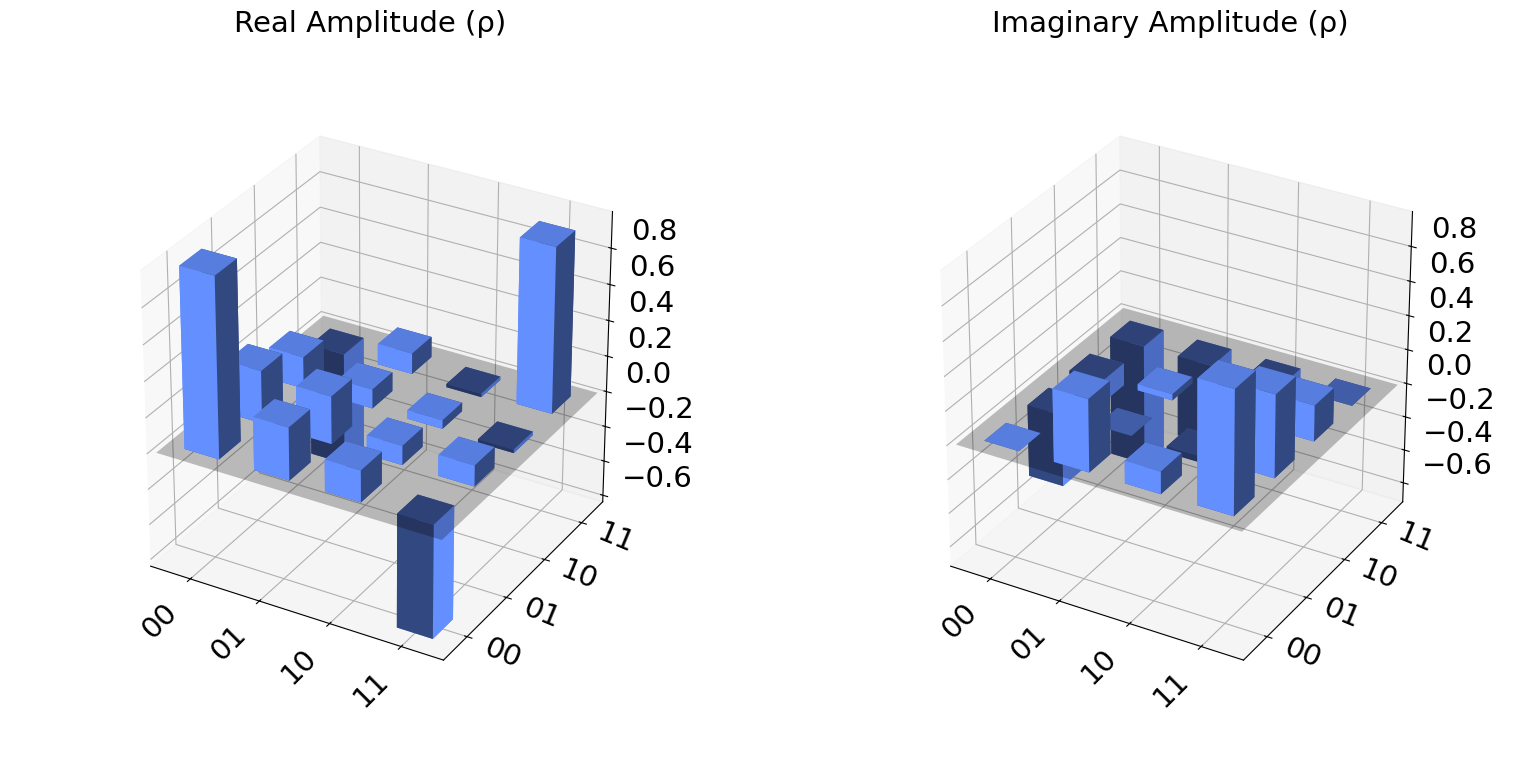

In [17]:
import matplotlib.pyplot as plt
# plt.title("State difference")
plot_state_city(state_diff)
# plt.show()

# Fault tolerant Trotterized transverse ising model